In [1]:
import numpy as np
import pandas as pd
import pygmt as gmt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/yohai/workspace/faultSlip/')
sys.path.append('/Users/yohai/workspace/GPS_processing/')
from utils import *
from faultSlip.inversion import Inversion
from faultSlip.utils import *

In [2]:
def get_disp():
    dip_slip = np.sin(np.radians(rake)) * slip
    strike_slip = np.cos(np.radians(rake)) * slip
    inv.solution = np.array([strike_slip, dip_slip])
    return inv.gps[0].save_model(inv.solution), inv
def get_plain_cords(inv):
    return np.stack([inv.plains[0].sources[0].p1, inv.plains[0].sources[0].p2, inv.plains[0].sources[0].p3, inv.plains[0].sources[0].p4])
def get_source_cords(s):
    plain_cords = np.stack([s.p1, s.p2, s.p3, s.p4])
    plain_cords_lat = origin_lat + m2dd(plain_cords[:, 1]*1e3)
    plain_cords_lon = origin_lon + m2dd(plain_cords[:, 0]*1e3, plain_cords_lat)
    return np.stack((plain_cords_lon, plain_cords_lat, plain_cords[:, 2])).T

In [3]:
lame_lambda, shear_mod = 320000.0, 320000.0

In [4]:
xx = np.linspace(0, 100e3, 1000)
yy = np.linspace(0, 100e3, 1000)
X, Y = np.meshgrid(xx, yy)
tdf= pd.DataFrame(dict(x=X.flatten(), y=Y.flatten(), id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten()*1e-3, lat=Y.flatten()*1e-3))
tdf.to_csv('ttt.csv')

# Left lateral strike slip movment
## strike 180
## dip 90
## strike element 1

In [26]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false,
	"origin_lat":31.5,
	"origin_lon":35.5
	},
"plains":
	{
	"plain1":
		{
		"dip":90,
		"strike":0,
		"plain_cord":[50, 10, 0.01],
		"plain_length":80,
		"width":[10],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":1,
		"dip_element":1,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('./__t.json', 'w') as f:
    f.write(parms)
inv = Inversion('./__t.json')
inv.solution = np.array([1.0, 0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)
disp = inv.gps[0].save_model(inv.solution)
da_up = xr.DataArray(
    data=disp.Up.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)
da_n = xr.DataArray(
    data=disp.N.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)
da_e = xr.DataArray(
    data=disp.E.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)


/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_49332/2639016515.py:4: SyntaxWarning: Short-form parameter (B) is not recommended. Use long-form parameter 'frame' instead.
  fig.basemap(
/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_49332/2639016515.py:20: SyntaxWarning: Short-form parameter (B) is not recommended. Use long-form parameter 'frame' instead.
  fig.basemap(
/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_49332/2639016515.py:34: SyntaxWarning: Short-form parameter (B) is not recommended. Use long-form parameter 'frame' instead.
  fig.basemap(


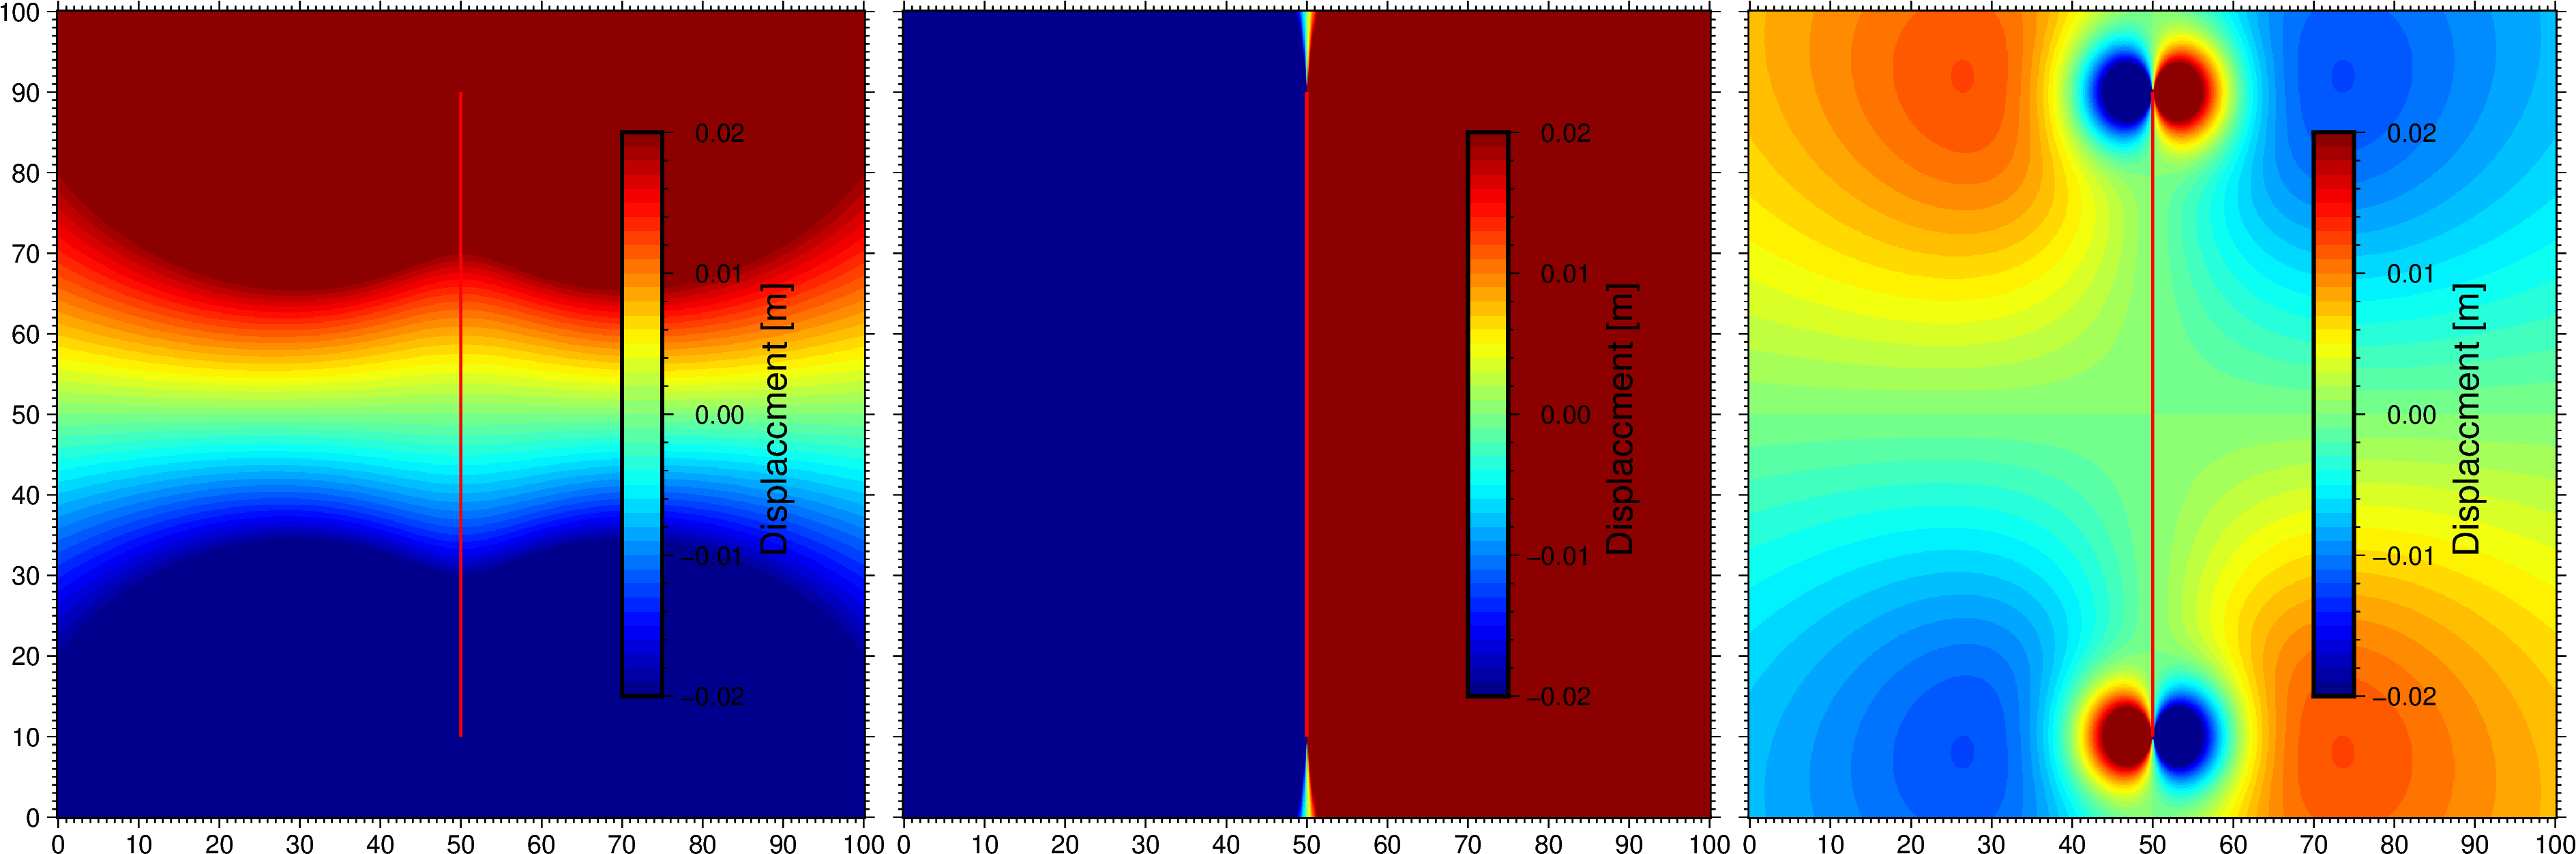

In [27]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    B=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
pygmt.makecpt(cmap="jet", series=[-0.02, 0.02, 0.001], background=True)

fig.grdimage(grid=da_e)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o-3c/0c+w7c/0.5c", frame='af+l"Displaccment [m] "')
fig.shift_origin(xshift='10.5c')
fig.basemap(
    B=['wSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
fig.grdimage(grid=da_n)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o-3c/0c+w7c/0.5c", frame='af+l"Displaccment [m] "')
fig.shift_origin(xshift='10.5c')
fig.basemap(
    B=['wSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
fig.grdimage(grid=da_up)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o-3c/0c+w7c/0.5c", frame='af+l"Displaccment [m] "')
fig.show(width=600)

## calculating the stress on the same orentaion (dip:90 strike:180)
## rake:180 represent left lateral movment

In [48]:
X, Y = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200))
Z = np.ones_like(X) * 5
dip = 90
strike = 0#plain.strike
rake = 180
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, strike, dip,
                                      rake, lambda_l=lame_lambda, shear_m=shear_mod)
shear_da = get_array(tn, X[0, :], Y[:, 0])
normal_da = get_array(ts, X[0, :], Y[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Y[:, 0])

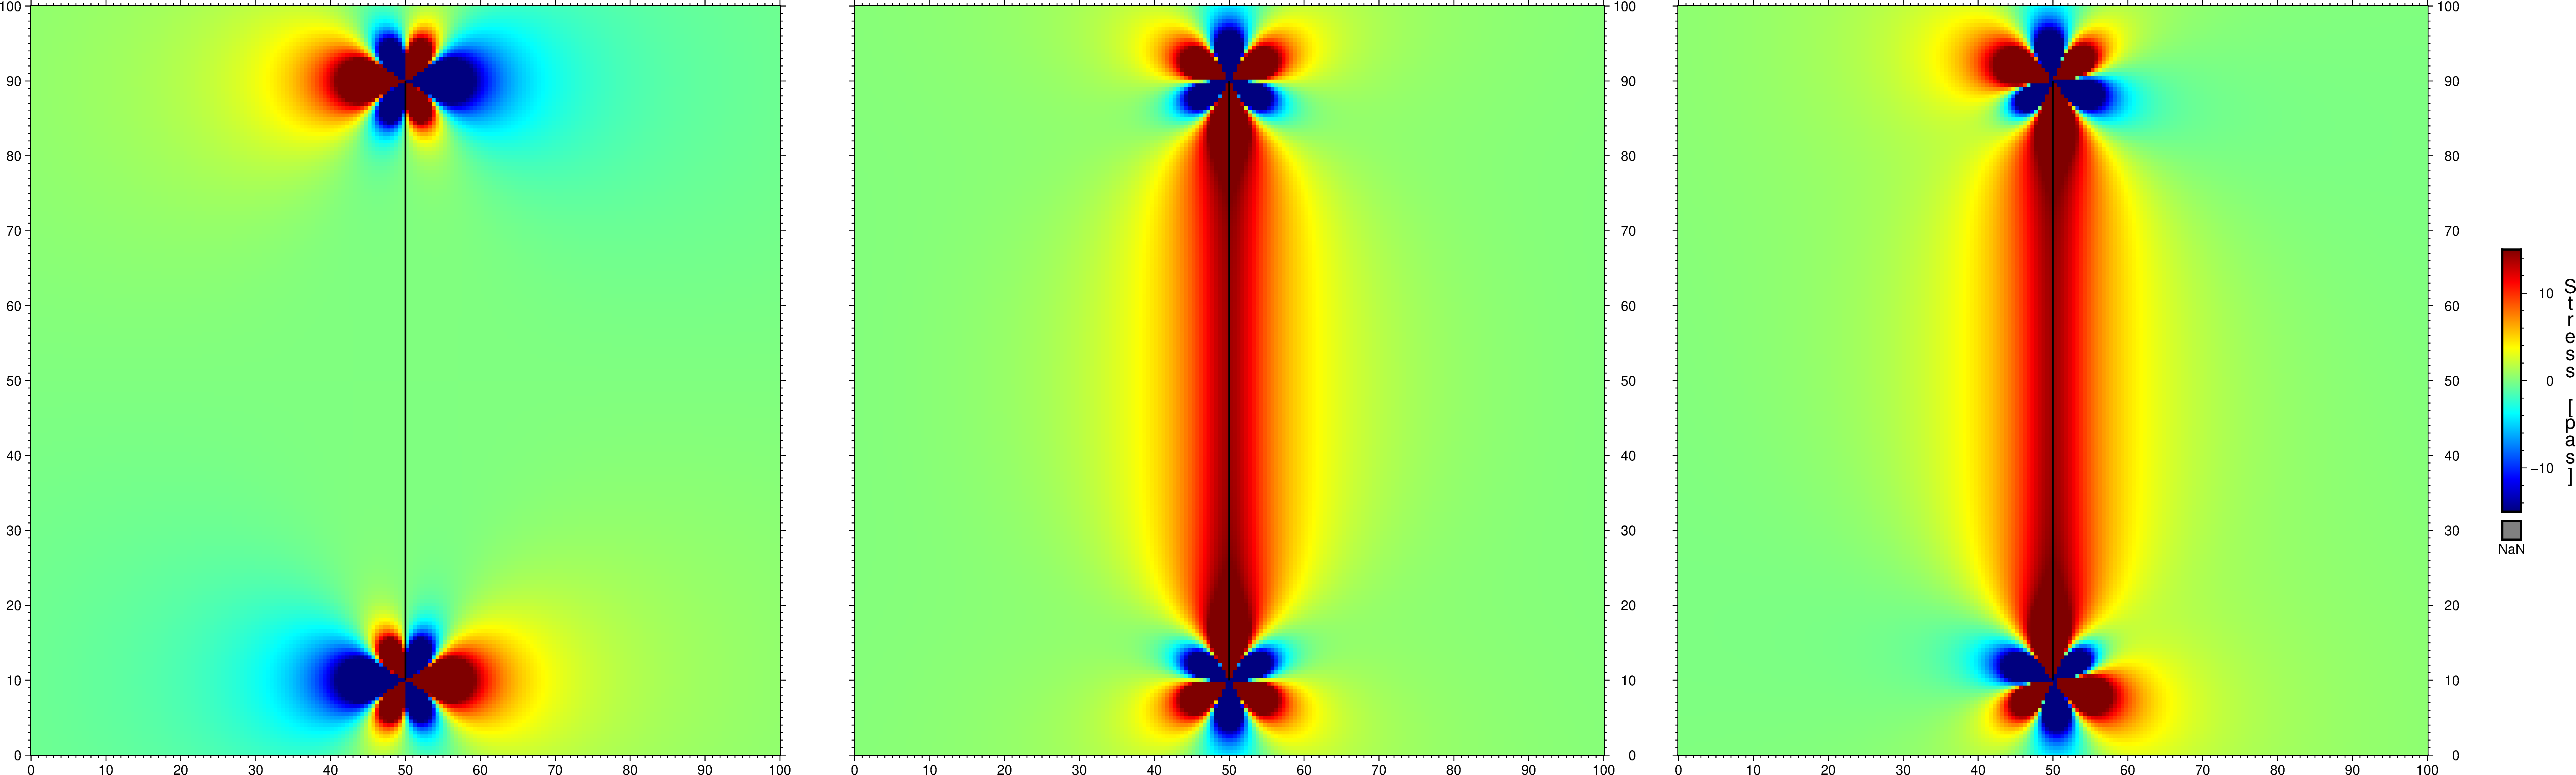

In [52]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = float(shear_da.max().data) * 0.05
mmin = float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="jet", series=[-15, 15, 0.01], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)

## A cross section view

In [41]:
X, Z = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, -20, 200))
Y = np.ones_like(X) * 50
dip = 90
strike = 0#plain.strike
rake = 180
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, strike, dip,
                                      rake, lambda_l=lame_lambda, shear_m=shear_mod)
shear_da = get_array(tn, X[0, :], Z[:, 0])
normal_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [43]:
shear_da

<xarray.DataArray (y: 200, x: 200)>
array([[-1.09638559e-17, -1.16912058e-17, -1.24536945e-17, ...,
        -1.24536945e-17, -1.16912058e-17, -1.09638559e-17],
       [-1.09194155e-17, -1.16465665e-17, -1.24088768e-17, ...,
        -1.24088768e-17, -1.16465665e-17, -1.09194155e-17],
       [-1.08748761e-17, -1.16018046e-17, -1.23639111e-17, ...,
        -1.23639111e-17, -1.16018046e-17, -1.08748761e-17],
       ...,
       [-4.27832364e-19, -7.62731975e-19, -1.11170912e-18, ...,
        -1.11170912e-18, -7.62731975e-19, -4.27832364e-19],
       [-3.74433907e-19, -7.06611889e-19, -1.05272150e-18, ...,
        -1.05272150e-18, -7.06611889e-19, -3.74433907e-19],
       [-3.21173076e-19, -6.50634678e-19, -9.93882527e-19, ...,
        -9.93882527e-19, -6.50634678e-19, -3.21173076e-19]])
Coordinates:
  * x        (x) float64 0.0 0.5025 1.005 1.508 2.01 ... 98.49 98.99 99.5 100.0
  * y        (y) float64 0.0 -0.1005 -0.201 -0.3015 ... -19.7 -19.8 -19.9 -20.0

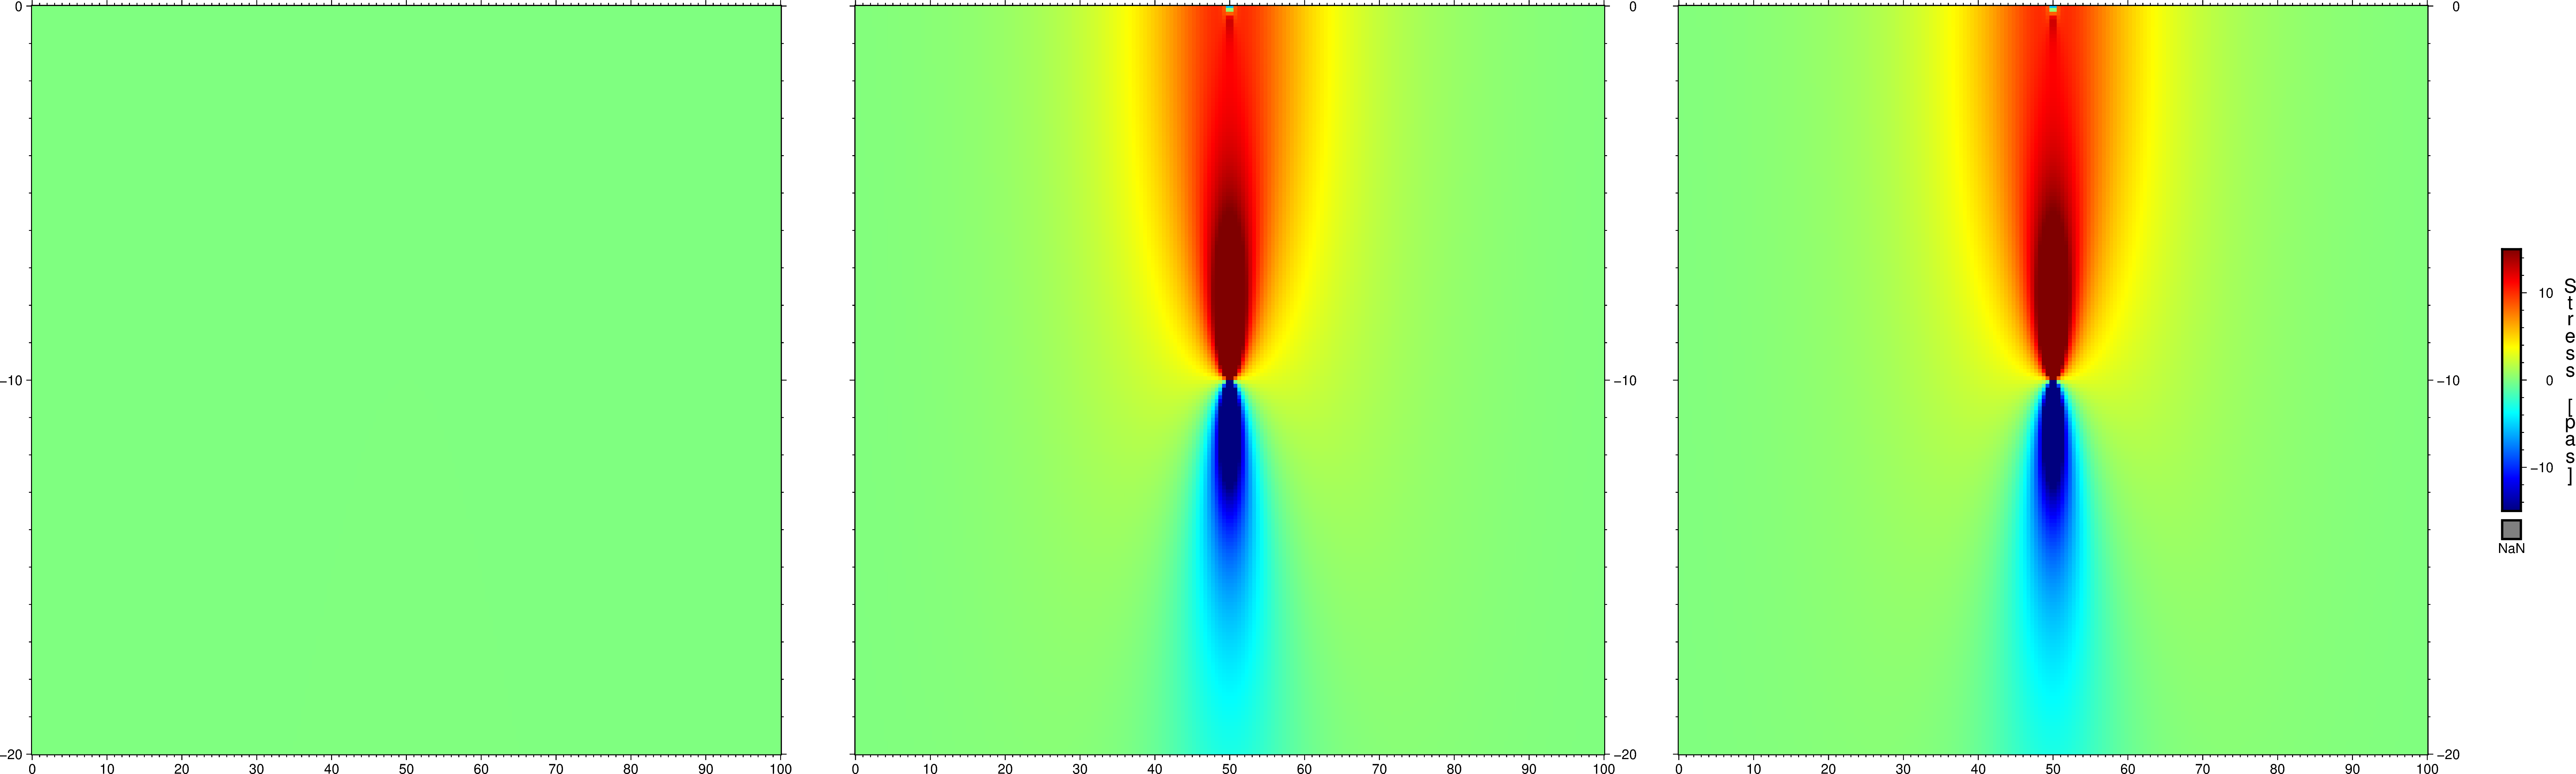

In [45]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, -20, 0]
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

pygmt.makecpt(cmap="jet", series=[-15, 15, 0.01], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)